In [1]:
import cleanlab
import sys
import numpy as np
import pandas as pd
import datetime
import copy
from pathlib import Path
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt

sys.path.insert(0, "../")
from eval_metrics import lift_at_k

from cleanlab.rank import order_label_issues, get_label_quality_scores, get_label_quality_ensemble_scores
from cleanlab.filter import find_label_issues

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

ModuleNotFoundError: No module named 'cleanlab.rank'

## Get verified labels for subset of data

In [3]:
path_verified_train = "/Data/Food-101N_release/meta/verified_train.tsv"

df_verified_train = pd.read_csv(path_verified_train, sep='\t')

df_verified_train.head(3)

,class_name/key,verification_label
0,apple_pie/7a6a67e05daf10b106ccd592baa0eadd.jpg,1
1,apple_pie/ddc6e9a24fd9333a9c30ef5659e17409.jpg,1
2,apple_pie/93fc8efb8dd49e58ebaf62852bd7dac0.jpg,1


## Evaluate scores

In [34]:
%%time

models = [
    "resnet18", 
    # "resnet50d",
    # "efficientnet_b1",
    # "twins_pcpvt_base",
    "swin_base_patch4_window7_224"
]

# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
    ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]

results_list = []
pred_probs_list = [] # use for ensemble scoring
labels_list = [] # use for sanity check (labels from each model should be the same because they were generated from the same cross-val procedure

for model in models:
    
    # read numpy files
    numpy_out_folder = f"./food-101n_cv_{model}/"
    pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
    labels = np.load(numpy_out_folder + "noisy_labels.npy")
    # true_labels = np.load(numpy_out_folder + "true_labels.npy")
    images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)
    
    #### Get boolean mask for subset of verified labels
    
    # instantiate DataFrame with all training data
    df_image_paths = pd.DataFrame({
        "class_name/key": pd.Series(images).map(lambda f: "/".join(Path(f).parts[-2:]))
    })

    # join to append verification_label column
    df_image_paths_w_verified = df_image_paths.merge(df_verified_train, on="class_name/key", how="left")

    # subset of data with verified labels
    verified_subset_mask = ~df_image_paths_w_verified.verification_label.isnull().values

    ####
    
    # filter on verified subset

    pred_probs = pred_probs[verified_subset_mask]
    labels = labels[verified_subset_mask]
    images = images[verified_subset_mask]    
    
    # boolean mask of label errors
    label_errors_target = df_image_paths_w_verified["verification_label"].values[verified_subset_mask] == 0
    
    
    # save to list for ensemble scoring
    pred_probs_list.append(pred_probs)
    
    labels_list.append(labels)
    
    for score_param in score_params:
        
        method, adjust_pred_probs = score_param

        # compute scores
        label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

        # compute accuracy of detecting label errors
        auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

        # compute Lift@K evaluation metric
        lift_at_k_dict = {}
        for k in range(1000, 11000, 1000):
            lift_at_k_dict[f"lift_at_{k}"] = lift_at_k(label_errors_target, 1 - label_quality_scores, k=k)

        # save results
        results = {
            "dataset": "food-101n-verified",
            "model": model,
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "auroc": auroc
        }

        # add the lift at k metrics
        results.update(lift_at_k_dict)

        # save results
        results_list.append(results)        

CPU times: user 24.3 s, sys: 1 s, total: 25.3 s
Wall time: 26.4 s


In [41]:
# use for sanity check (noisy labels from each model should be the same because they were generated from the same cross-val procedure
for i, labels_temp in enumerate(labels_list):
    
    if i == 0:
        # labels_temp_previous = labels_temp.copy()
        labels_temp_previous = copy.deepcopy(labels_temp)
    else:
        assert (labels_temp_previous == labels_temp).all()

## Evaluate ensemble scores

In [20]:
%%time

for score_param in score_params:

    method, adjust_pred_probs = score_param
    
    print(f"Scoring label quality...")
    print(f"  method: {method}")
    print(f"  adjust_pred_probs: {adjust_pred_probs}")

    label_quality_ensemble_scores = get_label_quality_ensemble_scores(labels, pred_probs_list, method=method, adjust_pred_probs=adjust_pred_probs)
    
    # compute accuracy of detecting label errors
    auroc = roc_auc_score(label_errors_target, 1 - label_quality_ensemble_scores)

    # compute Lift@K evaluation metric
    lift_at_k_dict = {}
    for k in range(1000, 21000, 1000):
        lift_at_k_dict[f"lift_at_{k}"] = lift_at_k(label_errors_target, 1 - label_quality_ensemble_scores, k=k)

    # save results
    results = {
        "dataset": "cifar-10n",
        "model": "ensemble (all)",
        "noise_type": "worse_label",
        "method": method,
        "adjust_pred_probs": adjust_pred_probs,
        "auroc": auroc
    }

    # add the lift at k metrics
    results.update(lift_at_k_dict)
    
    # save results
    results_list.append(results)

Scoring label quality...
  method: self_confidence
  adjust_pred_probs: False
Weighting scheme for ensemble: accuracy
Ensemble members will be weighted by: their relative accuracy
  Model 0 accuracy : 0.57788
  Model 0 weights  : 0.19538551006883867
  Model 1 accuracy : 0.5919
  Model 1 weights  : 0.20012577595650588
  Model 2 accuracy : 0.5804
  Model 2 weights  : 0.19623754074194294
  Model 3 accuracy : 0.60154
  Model 3 weights  : 0.20338513138853953
  Model 4 accuracy : 0.60592
  Model 4 weights  : 0.2048660418441731
Scoring label quality...
  method: self_confidence
  adjust_pred_probs: True
Weighting scheme for ensemble: accuracy
Ensemble members will be weighted by: their relative accuracy
  Model 0 accuracy : 0.57788
  Model 0 weights  : 0.19538551006883867
  Model 1 accuracy : 0.5919
  Model 1 weights  : 0.20012577595650588
  Model 2 accuracy : 0.5804
  Model 2 weights  : 0.19623754074194294
  Model 3 accuracy : 0.60154
  Model 3 weights  : 0.20338513138853953
  Model 4 accura

## Create DataFrame with results

In [42]:
df = pd.DataFrame(results_list)

In [43]:
df

,dataset,model,method,adjust_pred_probs,auroc,lift_at_1000,lift_at_2000,lift_at_3000,lift_at_4000,lift_at_5000,lift_at_6000,lift_at_7000,lift_at_8000,lift_at_9000,lift_at_10000
0,food-101n-verified,resnet18,self_confidence,False,0.898385,4.795242,4.632507,4.505936,4.347722,4.175766,3.985186,3.853707,3.702209,3.568706,3.416881
1,food-101n-verified,resnet18,self_confidence,True,0.849762,3.086530,3.094667,3.043134,2.980753,3.013842,2.959055,2.891249,2.824799,2.776732,2.684576
2,food-101n-verified,resnet18,normalized_margin,False,0.844335,3.303509,3.018724,2.833388,2.770554,2.676439,2.626353,2.593677,2.550185,2.503097,2.481700
3,food-101n-verified,resnet18,normalized_margin,True,0.839705,3.129926,2.940069,2.811690,2.716309,2.679694,2.653476,2.625449,2.619347,2.609176,2.592902
4,food-101n-verified,resnet18,confidence_weighted_entropy,False,0.897329,4.860336,4.692177,4.536675,4.378913,4.192040,4.025870,3.866881,3.717804,3.561474,3.410914
5,food-101n-verified,swin_base_patch4_window7_224,self_confidence,False,0.922289,5.001372,4.993236,4.871185,4.743709,4.570668,4.420049,4.269842,4.098874,3.926722,3.768388
6,food-101n-verified,swin_base_patch4_window7_224,self_confidence,True,0.900140,4.160578,3.970721,3.949023,3.866299,3.853552,3.787192,3.668500,3.580836,3.487942,3.396268
7,food-101n-verified,swin_base_patch4_window7_224,normalized_margin,False,0.890591,3.873080,3.591007,3.406575,3.329276,3.276387,3.247456,3.216718,3.193664,3.179349,3.154336
8,food-101n-verified,swin_base_patch4_window7_224,normalized_margin,True,0.891056,3.574734,3.439121,3.397534,3.375384,3.383792,3.380356,3.381002,3.372672,3.357152,3.311646
9,food-101n-verified,swin_base_patch4_window7_224,confidence_weighted_entropy,False,0.923406,5.142409,5.074603,4.947127,4.812872,4.641187,4.482430,4.317113,4.147694,3.962283,3.792255


## Export results to csv

In [44]:
# export results to CSV file
ts = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
df.to_csv(f"label_quality_scores_evaluation_{ts}.csv", index=False)

## Evaluate precision-recall and F1-score

In [22]:
model = "swin_base_patch4_window7_224"
numpy_out_folder = f"./food-101n_cv_{model}/"

pred_probs = np.load(numpy_out_folder + "pred_probs.npy")
labels = np.load(numpy_out_folder + "noisy_labels.npy")
images = np.load(numpy_out_folder + "images.npy", allow_pickle=True)

In [23]:
pred_probs.shape

(310009, 101)

In [24]:
# instantiate DataFrame with all training data
df_image_paths = pd.DataFrame({
    "class_name/key": pd.Series(images).map(lambda f: "/".join(Path(f).parts[-2:]))
})

# join to append verification_label column
df_image_paths_w_verified = df_image_paths.merge(df_verified_train, on="class_name/key", how="left")

# subset of data with verified labels
verified_subset_mask = ~df_image_paths_w_verified.verification_label.isnull().values

df_image_paths_w_verified.head()

,class_name/key,verification_label
0,apple_pie/000036ee3613531a745a05052e6a3ed7.jpg,NaN
1,apple_pie/00168d0c6df7fb7b7b786a22c2ff2f4a.jpg,1.0
2,apple_pie/00196077deceacae8f88408b7e0cc216.jpg,NaN
3,apple_pie/003ba1197bb2ffca00036bbd1bfae139.jpg,NaN
4,apple_pie/00861f70adfd37898114b83ff16978d0.jpg,1.0


In [25]:
# filter on verified subset

pred_probs_subset = pred_probs[verified_subset_mask]
labels_subset = labels[verified_subset_mask]
images_subset = images[verified_subset_mask]

# label error boolean mask for subset of verified labels
label_errors_target_subset = df_image_paths_w_verified["verification_label"].values[verified_subset_mask] == 0

## Evaluate different filter_by options

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# pointer
true_label_issues = label_errors_target_subset

# code below adapted from v2.0.0 docs
# https://colab.research.google.com/github/cleanlab/cleanlab-docs/blob/master/v2.0.0/tutorials/indepth_overview.ipynb#scrollTo=kCfdx2gOLmXS

# Find label issues with different filter_by options
filter_by_list = [
    "prune_by_noise_rate",
    "prune_by_class",
    "both",
    "confident_learning",
    "predicted_neq_given",
]

results = []

for filter_by in filter_by_list:

    # Find label issues
    label_issues = cleanlab.filter.find_label_issues(
        labels=labels_subset, 
        pred_probs=pred_probs_subset, 
        filter_by=filter_by
    )
    
    precision = precision_score(true_label_issues, label_issues)
    recall = recall_score(true_label_issues, label_issues)
    f1 = f1_score(true_label_issues, label_issues)
    acc = accuracy_score(true_label_issues, label_issues)
    
    result = {
        "filter_by": filter_by,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": acc,
        "num_est_label_issues": label_issues.sum()
    }
    
    results.append(result)

# summary of results
# pd.DataFrame(results).sort_values(by='f1', ascending=False)

df_filter_by = pd.DataFrame(results)

df_filter_by

,filter_by,precision,recall,f1,accuracy,num_est_label_issues
0,prune_by_noise_rate,0.550756,0.340140,0.420552,0.827208,6019
1,prune_by_class,0.754151,0.484712,0.590131,0.875877,6264
2,both,0.709610,0.242458,0.361426,0.842056,3330
3,confident_learning,0.526421,0.215678,0.305990,0.819642,3993
4,predicted_neq_given,0.551201,0.816848,0.658233,0.843626,14443


## Plot precision-recall curve

Scoring label quality...
  method: self_confidence
  adjust_pred_probs: False
Scoring label quality...
  method: normalized_margin
  adjust_pred_probs: False
Scoring label quality...
  method: confidence_weighted_entropy
  adjust_pred_probs: False


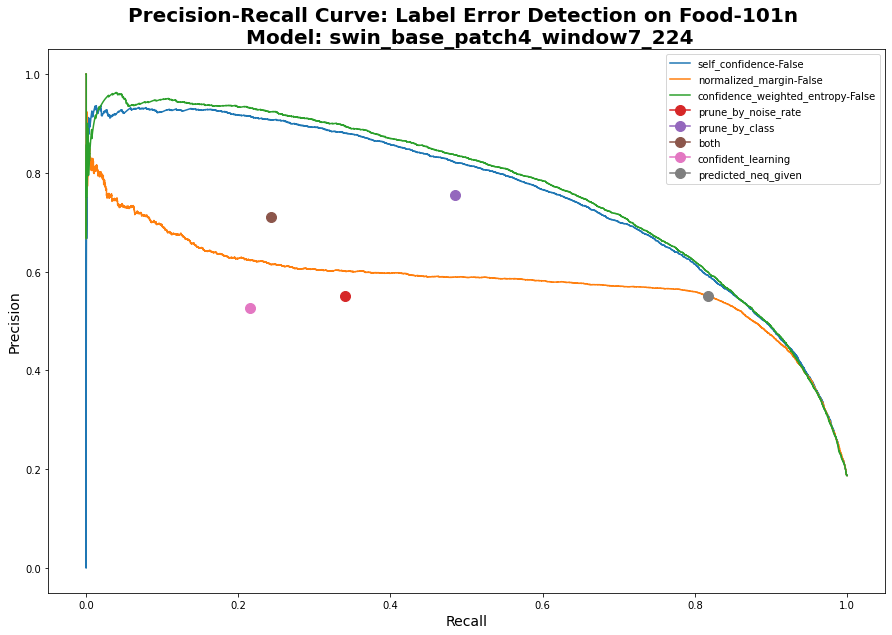

CPU times: user 7.38 s, sys: 394 ms, total: 7.78 s
Wall time: 7.55 s


In [32]:
%%time

plt.rcParams["figure.figsize"] = (15, 10)

score_params = \
[
    ("self_confidence", False),
    # ("self_confidence", True),
    ("normalized_margin", False),
    # ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]

df_list = []

for score_param in score_params:

    method, adjust_pred_probs = score_param
    
    print(f"Scoring label quality...")
    print(f"  method: {method}")
    print(f"  adjust_pred_probs: {adjust_pred_probs}")

    label_quality_scores = get_label_quality_scores(labels_subset, pred_probs_subset, method=method, adjust_pred_probs=adjust_pred_probs)

    # compute accuracy of detecting label errors
    auroc = roc_auc_score(label_errors_target_subset, 1 - label_quality_scores)

    # compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(label_errors_target_subset, 1 - label_quality_scores)

    # save to DataFrame
    # ignore last precision, recall value because it's always 1, 0 respectively with no corresponding threshold
    # https://stackoverflow.com/questions/31639016/in-scikits-precision-recall-curve-why-does-thresholds-have-a-different-dimensi
    df_temp = pd.DataFrame({
        "precision": precision[:-1],
        "recall": recall[:-1],
        "thresholds": thresholds,
        "model": model,
        "method": method,
        "adjust_pred_probs": adjust_pred_probs
    })

    df_list.append(df_temp)
    
    # plot
    plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}")
    
# combine DataFrames
# df_all = pd.concat(df_list)

# plot single dot (precision, recall) for each filter_by option
for index, row in df_filter_by.iterrows():
    filter_by = row["filter_by"]
    precision = row["precision"]
    recall = row["recall"]
    plt.plot(recall, precision, marker="o", markersize=10, label=filter_by)

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision-Recall Curve: Label Error Detection on Food-101n \n Model: swin_base_patch4_window7_224", fontsize=20, fontweight="bold")
# plt.suptitle("")
plt.legend()
plt.show()

Scoring label quality...
  method: self_confidence
  adjust_pred_probs: True
Scoring label quality...
  method: normalized_margin
  adjust_pred_probs: True
Scoring label quality...
  method: confidence_weighted_entropy
  adjust_pred_probs: False


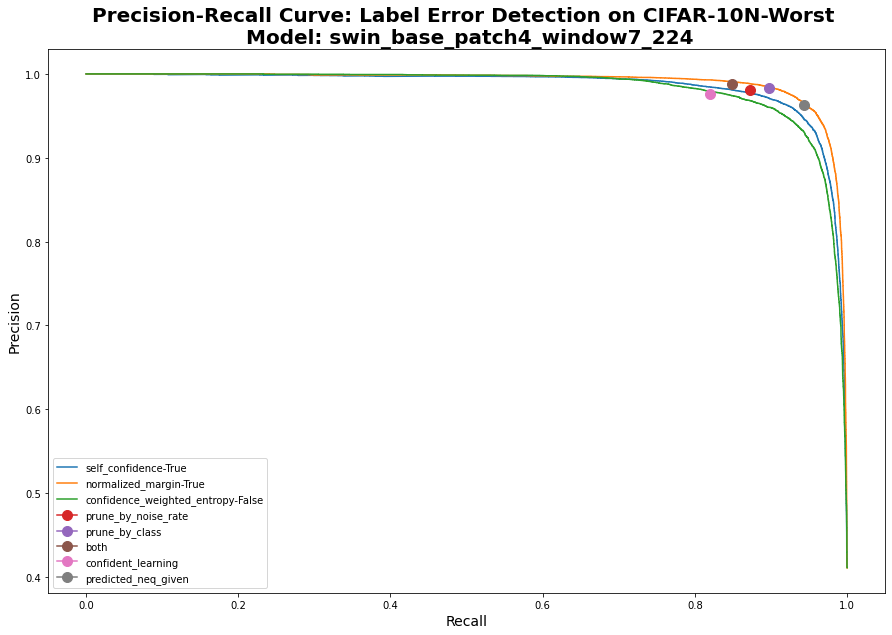

CPU times: user 4.14 s, sys: 138 ms, total: 4.28 s
Wall time: 4.02 s


In [68]:
%%time

plt.rcParams["figure.figsize"] = (15, 10)

score_params = \
[
    # ("self_confidence", False),
    ("self_confidence", True),
    # ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]

df_list = []

for score_param in score_params:

    method, adjust_pred_probs = score_param
    
    print(f"Scoring label quality...")
    print(f"  method: {method}")
    print(f"  adjust_pred_probs: {adjust_pred_probs}")

    label_quality_scores = get_label_quality_scores(labels, pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

    # compute accuracy of detecting label errors
    auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)

    # compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores)

    # save to DataFrame
    # ignore last precision, recall value because it's always 1, 0 respectively with no corresponding threshold
    # https://stackoverflow.com/questions/31639016/in-scikits-precision-recall-curve-why-does-thresholds-have-a-different-dimensi
    df_temp = pd.DataFrame({
        "precision": precision[:-1],
        "recall": recall[:-1],
        "thresholds": thresholds,
        "model": model,
        "method": method,
        "adjust_pred_probs": adjust_pred_probs
    })

    df_list.append(df_temp)
    
    # plot
    plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}")
    
# combine DataFrames
# df_all = pd.concat(df_list)

# plot single dot (precision, recall) for each filter_by option
for index, row in df_filter_by.iterrows():
    filter_by = row["filter_by"]
    precision = row["precision"]
    recall = row["recall"]
    plt.plot(recall, precision, marker="o", markersize=10, label=filter_by)

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision-Recall Curve: Label Error Detection on CIFAR-10N-Worst \n Model: swin_base_patch4_window7_224", fontsize=20, fontweight="bold")
# plt.suptitle("")
plt.legend()
plt.show()

In [41]:


# plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}")
# plt.legend()
plt.show()

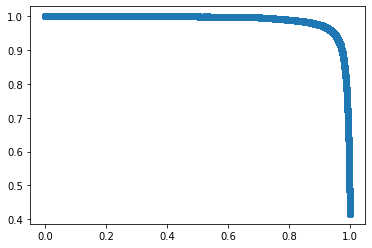

In [20]:
# plot

plt.scatter(
    x=recall, 
    y=precision
)

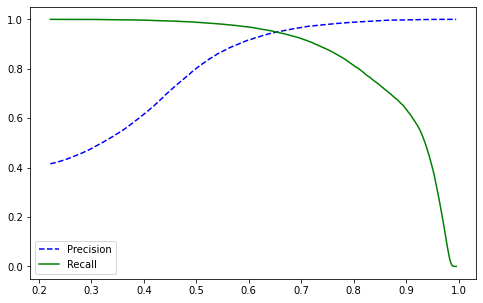

In [27]:
def plot_precision_recall_vs_threshold(precisions, recall, thresholds): 
    fig = plt.figure(figsize= (8,5))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.legend()

plot_precision_recall_vs_threshold(precision, recall, thresholds)